### Class Activation Mappings

Class Activation Mappings (CAM) can provide some insight into the decision area that a model determine to classify a image. It is done by overlaying a heatmap over the original image to show us where the model thought most strongly to determine the result. 

In [20]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import transforms, models
import torch.nn.functional as F
from torch import topk
import skimage

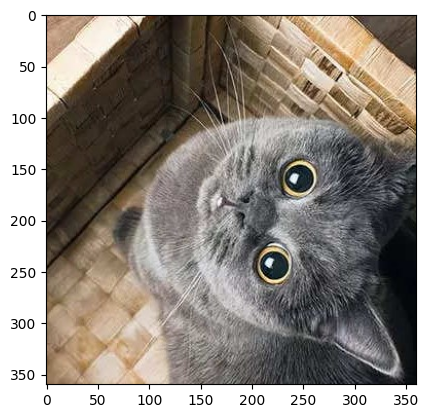

In [21]:
image = Image.open('./cat.jpg')
plt.imshow(image)

In [22]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

display_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
])

In [23]:
model = models.resnet18(weights="DEFAULT").cuda()
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Codes below allow you to easily attach a hook to any model (or any part of a model - here we are going to grab the final convnet layer in ResNet18) which will save the activation features as an instance variable.

In [24]:
class SaveFeatures():
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_fn)
    
    def hook_fn(self, module, input, output):
        self.features = ((output.cpu()).data).numpy()

    def remove(self):
        self.hook.remove()

In [25]:
activated_features = SaveFeatures(model.layer4)

Having set that up, we simply run the image through the model and get the prediction, and run that through a softmax layer to turn it into probabilities.

In [26]:
image_tensor = transform(image)

prediction = model(image_tensor.unsqueeze(0).cuda())
probabilities = F.softmax(prediction).data.squeeze()

activated_features.remove()

(tensor([[[[1.0714e+00, 1.3787e-01, 0.0000e+00,  ..., 3.6769e-01,
           4.9950e-01, 3.7237e-01],
          [2.8361e-01, 0.0000e+00, 0.0000e+00,  ..., 1.5316e-01,
           2.3268e-01, 6.1632e-02],
          [2.5735e-01, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           1.4874e-01, 8.4986e-02],
          ...,
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 2.7455e-01,
           1.8711e-01, 7.9637e-02],
          [3.7171e-02, 0.0000e+00, 4.3934e-02,  ..., 1.2805e-01,
           3.8364e-01, 2.5770e-01],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 9.1216e-02,
           2.6378e-01, 8.3798e-02]],

         [[1.4421e-01, 3.2062e-01, 3.3945e-01,  ..., 3.1420e-01,
           2.1519e-01, 0.0000e+00],
          [1.2213e-01, 6.0774e-02, 6.8637e-02,  ..., 1.5153e-01,
           1.9524e-01, 3.9540e-02],
          [5.2367e-01, 1.8862e-01, 1.9046e-01,  ..., 4.3130e-01,
           3.9172e-01, 2.1926e-01],
          ...,
          [1.9211e-01, 1.0191e-01, 1.2374e-02,  ..., 6.718

C:\Users\micha\AppData\Local\Temp\ipykernel_31688\1817570470.py:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = F.softmax(prediction).data.squeeze()


Using topk(), we can see that our model is 51% confident that this picture is class 287.

In [27]:
topk(probabilities, 1)

torch.return_types.topk(
values=tensor([0.5159], device='cuda:0'),
indices=tensor([24], device='cuda:0'))

Having made the guess, let's see where the neural network was focusing its attention.
The getCAM() method here takes the activated features of the convnet, the weights of thefully-connected layer (on the side of the average pooling), and the class index we want to investigate (287 in our case).
We index into the fully-connected layer to get the weights for that class and calculate the dot product with our featues from the image.

In [28]:
def getCAM(feature_conv, weight_fc, class_idx):
    _, c, h, w = feature_conv.shape
    cam = weight_fc[class_idx].dot(feature_conv.reshape(c, h*w))
    cam = cam.reshape(h, w)
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    
    return [cam_img]

In [29]:
weight_params = list(model.fc.parameters())
weight_softmax = np.squeeze(weight_params[0].cpu().data.numpy())

class_idx = topk(probabilities, 1)[1].int()
overlay = getCAM(activated_features.features, weight_softmax, class_idx)

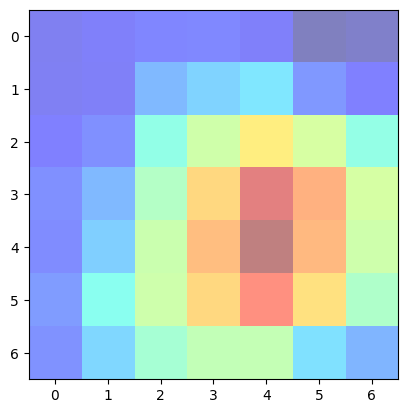

In [30]:
plt.imshow(overlay[0], alpha=0.5, cmap='jet')

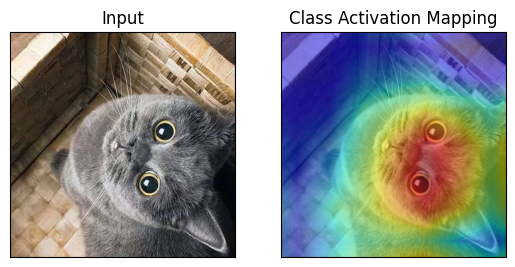

In [31]:
plt.subplot(1, 2, 1)
plt.title('Input')
plt.tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
plt.imshow(image)
plt.subplot(1, 2, 2)
plt.title('Class Activation Mapping')
plt.tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
plt.imshow(display_transforms(image))
plt.imshow(skimage.transform.resize(overlay[0], image_tensor.shape[1:3]), alpha=0.5, cmap='jet')
plt.savefig('./cam.png')